In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os 
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

***
## Data cleaning

In [ ]:
df = pd.read_csv('soal.csv')

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [ ]:
holidays = pd.to_datetime(['2020-06-03', '2020-06-04', '2020-06-05', '2020-06-12',
                           '2020-06-17', '2020-06-19', '2020-06-26', '2020-07-03',
                           '2020-07-10', '2020-07-17', '2020-07-24', '2020-07-31'])

In [ ]:
df_date = df['date_time'].dt.date
df['minute'] = df['date_time'].dt.minute 
df['hour'] = df['date_time'].dt.hour
df['dayofmonth'] = df['date_time'].dt.day
df['dayofyear'] = df['date_time'].dt.dayofyear
df['dayofweek'] = df['date_time'].dt.dayofweek 
df['weekofyear'] = df['date_time'].dt.weekofyear
df['month'] = df['date_time'].dt.month
df['quarter'] = df['date_time'].dt.quarter
df['year'] = df['date_time'].dt.year
df['isholiday'] = [1 if date in holidays else 0 for date in df_date ]

In [ ]:
df.drop(columns={'date_time'}, inplace=True)
cols = [col for col in df if col != 'speed2'] 
df = df[cols + ['speed2']]
df.head(2)

,count,speed1,minute,hour,dayofmonth,dayofyear,dayofweek,weekofyear,month,quarter,year,isholiday,speed2
0,42,74.5,0,0,1,153,0,23,6,2,2020,0,73.0
1,46,73.0,15,0,1,153,0,23,6,2,2020,0,74.0


***
## Training

In [ ]:
first_row = (df['speed2'] == -1).argmax()
train_set = df[0:first_row]

In [ ]:
# Scaling the training set
scaler = MinMaxScaler(feature_range=(0,1))
train_set_scaled = pd.DataFrame(scaler.fit_transform(train_set), columns=cols + ['speed2'])
train_set_scaled.head(2)

,count,speed1,minute,hour,dayofmonth,dayofyear,dayofweek,weekofyear,month,quarter,year,isholiday,speed2
0,0.161943,0.718085,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812903
1,0.178138,0.702128,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825806


In [ ]:
train_set_scaled.shape

(5407, 13)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 

ts = 10
len = train_set.shape[0]
X_train = []
y_train = []

for i in range(ts, len):
  X_train.append(train_set_scaled.loc[i-ts:i, cols].to_numpy())
  y_train.append(train_set_scaled.loc[i, 'speed2'])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(5397, 11, 12)

In [ ]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 11, 50)            12600     
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 11, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fitting to the training set
history = regressor.fit(x = X_train, 
                        y = y_train, 
                        epochs = 100, 
                        batch_size = 32, 
                        callbacks = [tensorboard_callback])

Epoch 1/100
  1/169 [..............................] - ETA: 0s - loss: 0.7523WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
169/169 [==============================] - 3s 19ms/step - loss: 0.0379
Epoch 2/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0079
Epoch 3/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0069
Epoch 4/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0064
Epoch 5/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0061
Epoch 6/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0059
Epoch 7/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0054
Epoch 8/100
169/169 [==============================] - 3s 19ms/step - loss: 

Text(0.5, 1.0, 'Train loss')

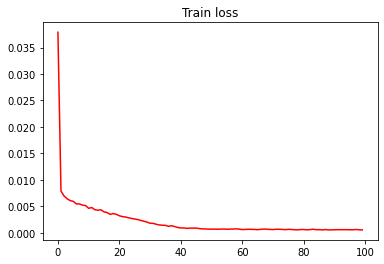

In [ ]:
train_loss = history.history['loss']
plt.plot(train_loss, color='r')
plt.title('Train loss')

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs

***
## Predicting

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values 

# Defining test set
test_set = df[first_row-ts:]
#test_set = df[2529-ts:2881]
test_set.shape

(459, 13)

In [ ]:
# Scaling the test set
test_set_scaled = pd.DataFrame(scaler.transform(test_set), columns=cols + ['speed2'])
print(test_set_scaled.shape)
test_set_scaled.tail(2)

NameError: ignored

In [ ]:
# Preparing X_test and predicting speed2
len = test_set.shape[0]
X_test = []

for i in range(ts, len):
  X_test.append(test_set_scaled.loc[i-ts:i, cols].to_numpy())

X_test = np.array(X_test)
print(X_test.shape)

(449, 11, 12)


In [ ]:
y_test = regressor.predict(X_test)
y_test = np.array(y_test)
y_test = y_test.reshape((1,-1))
y_test.shape

(1, 449)

In [ ]:
test_set_scaled.loc[ts:, 'speed2'] = y_test
test_set_scaled.tail(2)

,count,speed1,minute,hour,dayofmonth,dayofyear,dayofweek,weekofyear,month,quarter,year,isholiday,speed2
457,0.364372,0.670213,0.666667,1.0,1.034483,1.071429,0.666667,1.0,1.0,1.0,0.0,1.0,0.768206
458,0.311741,0.680851,1.000000,1.0,1.034483,1.071429,0.666667,1.0,1.0,1.0,0.0,1.0,0.771747


In [ ]:
predicted = pd.DataFrame(scaler.inverse_transform(test_set_scaled), columns= cols+['speed2'])
predicted = predicted.loc[ts:, 'speed2']

In [ ]:
predicted.to_csv('submit.csv', header=False, index=False)

***
## Comparing predicted outputs

Text(0.5, 1.0, 'Comparing predicted outputs of LSTM and prophet')

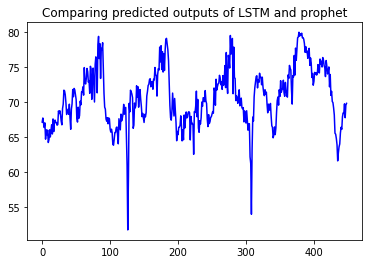

In [ ]:
# Visualizing the results for LSTM
plt.plot(predicted.values, color='b', label='LSTM')
#plt.plot(df.loc[2529:2881, 'speed2'].values, color='r', label='Prophet')
plt.title('Comparing predicted outputs of LSTM and prophet')

In [ ]:
#yhat_val = predicted.values
#y_val = df.loc[2529:2880, 'speed2'].values
 
#error = np.sum(np.abs((yhat_val - y_val) / y_val))
#print(error)